In [1]:
from google.colab import drive
import zipfile
import os


drive.mount('/content/drive')


zip_path = '/content/drive/MyDrive/fer2013.csv.zip'
extract_path = '/content/dataset'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")


Mounted at /content/drive
Files extracted to /content/dataset


In [2]:
import pandas as pd


csv_path = os.path.join(extract_path, 'fer2013.csv')
data = pd.read_csv(csv_path)


print(data.head())
print(data['Usage'].value_counts())


   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


In [3]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Load an image, resize it, and normalize to [0, 1].
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image

def add_salt_pepper_noise(image, salt_vs_pepper=0.5, amount=0.02):
    """
    Add salt and pepper noise to an image.
    """
    noisy = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_vs_pepper))


    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 1


    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 0

    return noisy


train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PrivateTest']
test_data = data[data['Usage'] == 'PublicTest']


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2

def reconstruct_image(pixels, target_size=(128, 128)):
    """
    Reconstruct an image from a flattened string of pixel values.
    :param pixels: Flattened string of pixel values
    :param target_size: Target size to resize the image
    :return: Reconstructed image as a NumPy array
    """

    pixel_array = np.array([int(p) for p in pixels.split()]).reshape(48, 48)


    pixel_array = pixel_array / 255.0


    resized_image = cv2.resize(pixel_array, target_size)


    rgb_image = np.stack([resized_image] * 3, axis=-1)

    return rgb_image


def add_salt_pepper_noise(image, amount=0.02):
    """
    Add salt-and-pepper noise to an image.
    :param image: Input image (NumPy array)
    :param amount: Proportion of pixels to corrupt
    :return: Noisy image
    """
    noisy_image = image.copy()
    num_salt = int(np.ceil(amount * image.size * 0.5))
    num_pepper = int(np.ceil(amount * image.size * 0.5))


    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 1


    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image


class ImageDataset(Dataset):
    def __init__(self, data, target_size=(128, 128)):
        """
        Custom Dataset for loading and preprocessing images.
        :param data: DataFrame containing the `pixels` column and `usage` column
        :param target_size: Target size to resize images
        """
        self.data = data
        self.target_size = target_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]


        clean_image = reconstruct_image(row['pixels'], self.target_size)


        noisy_image = add_salt_pepper_noise(clean_image)


        clean_image = torch.tensor(clean_image.transpose(2, 0, 1), dtype=torch.float32)
        noisy_image = torch.tensor(noisy_image.transpose(2, 0, 1), dtype=torch.float32)

        return noisy_image, clean_image



train_dataset = ImageDataset(train_data)
val_dataset = ImageDataset(val_data)
test_dataset = ImageDataset(test_data)


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for noisy_imgs, clean_imgs in tqdm(loader, desc="Training", leave=False):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)


        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_imgs.size(0)

    return running_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(loader, desc="Validation", leave=False):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)


            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)

            running_loss += loss.item() * noisy_imgs.size(0)

    return running_loss / len(loader.dataset)


def psnr(img1, img2):
    mse = ((img1 - img2) ** 2).mean().item()
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(torch.tensor(mse)))


def test_model(model, loader, device):
    model.eval()
    psnr_scores = []

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(loader, desc="Testing", leave=False):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)


            outputs = model(noisy_imgs)


            batch_psnr = psnr(outputs, clean_imgs)
            psnr_scores.append(batch_psnr)

    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    return avg_psnr


In [6]:
import torch
import torch.nn as nn

class ConvModule(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, padding=1, dropout_rate=0.2, stride=1):
        super().__init__()
        self.layer_sequence = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, padding=padding),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm2d(output_channels),

            nn.Conv2d(output_channels, output_channels, kernel_size, padding=padding, stride=stride),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate),
            nn.BatchNorm2d(output_channels),
        )

    def forward(self, inputs):
        return self.layer_sequence(inputs)


class UpConvModule(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, padding=1, dropout_rate=0.2):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size,
                                         padding=1, stride=2, output_padding=1)
        self.conv_sequence = ConvModule(output_channels * 2, output_channels, kernel_size, padding, dropout_rate)

    def forward(self, inputs, skip_connection):
        upsampled = self.upconv(inputs)
        concatenated = torch.cat([upsampled, skip_connection], dim=1)
        return self.conv_sequence(concatenated)


class DenoisingUNet(nn.Module):
    def __init__(self, base_channels=64, final_output_channels=3, dropout_rate=0.2):
        super().__init__()


        self.encoder_blocks = nn.ModuleList([
            ConvModule(3, base_channels, dropout_rate=dropout_rate),
            ConvModule(base_channels, base_channels * 2, stride=2, dropout_rate=dropout_rate),
            ConvModule(base_channels * 2, base_channels * 4, stride=2, dropout_rate=dropout_rate),
            ConvModule(base_channels * 4, base_channels * 8, stride=2, dropout_rate=dropout_rate),
            ConvModule(base_channels * 8, base_channels * 16, stride=2, dropout_rate=dropout_rate)
        ])


        self.decoder_blocks = nn.ModuleList([
            UpConvModule(base_channels * 16, base_channels * 8, dropout_rate=dropout_rate),
            UpConvModule(base_channels * 8, base_channels * 4, dropout_rate=dropout_rate),
            UpConvModule(base_channels * 4, base_channels * 2, dropout_rate=dropout_rate),
            UpConvModule(base_channels * 2, base_channels, dropout_rate=dropout_rate),
        ])


        self.final_layer = nn.Conv2d(base_channels, final_output_channels, kernel_size=3, padding=1)

    def forward(self, inputs):

        enc1 = self.encoder_blocks[0](inputs)
        enc2 = self.encoder_blocks[1](enc1)
        enc3 = self.encoder_blocks[2](enc2)
        enc4 = self.encoder_blocks[3](enc3)
        bottleneck = self.encoder_blocks[4](enc4)


        dec1 = self.decoder_blocks[0](bottleneck, enc4)
        dec2 = self.decoder_blocks[1](dec1, enc3)
        dec3 = self.decoder_blocks[2](dec2, enc2)
        dec4 = self.decoder_blocks[3](dec3, enc1)


        outputs = self.final_layer(dec4)

        return outputs


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingUNet(base_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5


best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")


    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")


    val_loss = validate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_model.pth")
        print("Model saved!")


print("Testing the best model...")
model.load_state_dict(torch.load("best_unet_model.pth"))
avg_psnr = test_model(model, test_loader, device)
print(f"Average PSNR on test set: {avg_psnr:.2f}")


Epoch 1/5


Training Loss: 0.0121


Validation Loss: 0.0007
Model saved!
Epoch 2/5


Training Loss: 0.0032


Validation Loss: 0.0025
Epoch 3/5


Training Loss: 0.0025


Validation Loss: 0.0004
Model saved!
Epoch 4/5


Training Loss: 0.0021


Validation Loss: 0.0011
Epoch 5/5


Training Loss: 0.0016


<ipython-input-8-397cb67e8df5>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet_model.pth"))


Validation Loss: 0.0003
Model saved!
Testing the best model...


Average PSNR on test set: 35.45


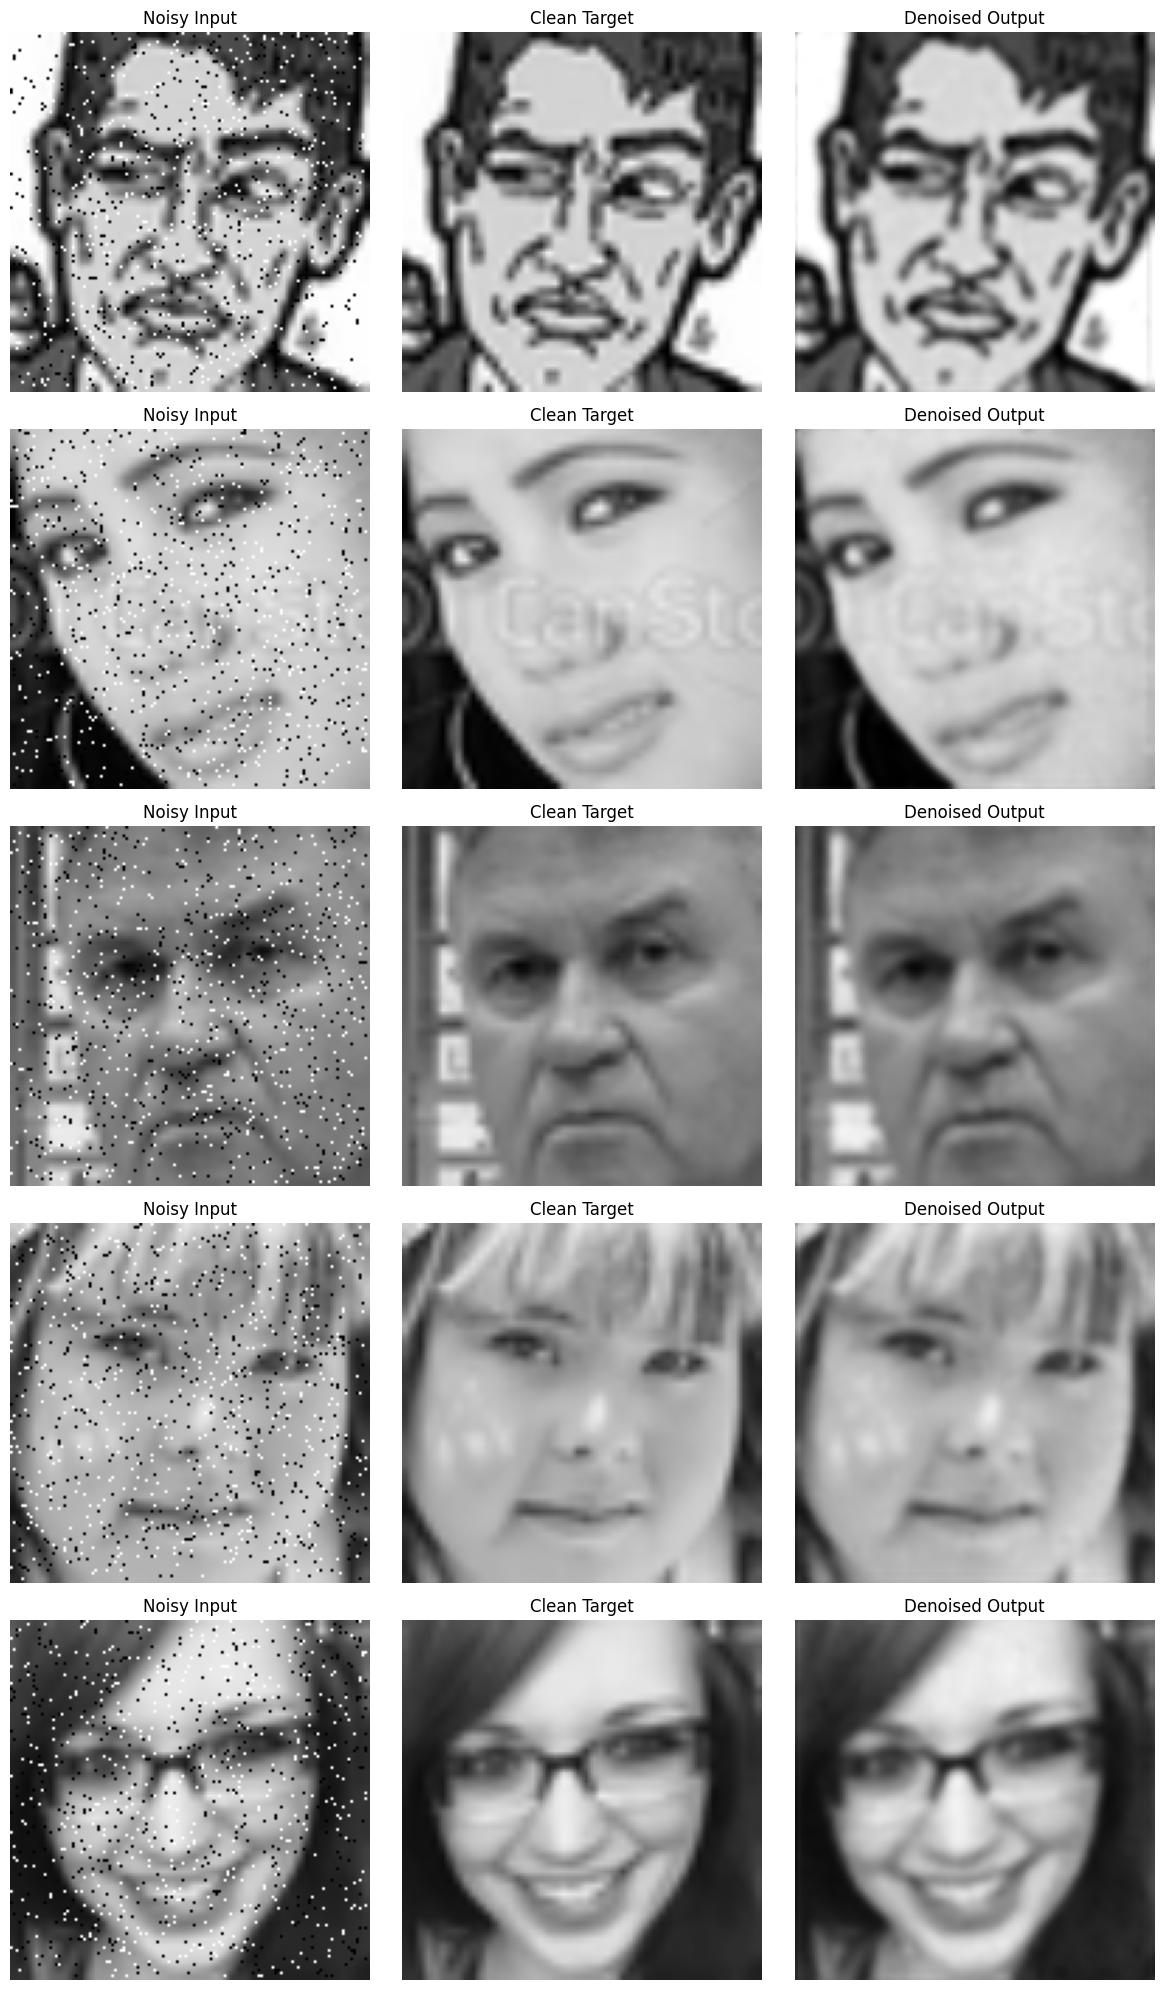

In [9]:
import matplotlib.pyplot as plt

def visualize_results(model, loader, device, num_images=5):
    model.eval()
    noisy_imgs, clean_imgs, outputs = [], [], []

    with torch.no_grad():
        for noisy_batch, clean_batch in loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
            output_batch = model(noisy_batch)

            noisy_imgs.extend(noisy_batch.cpu())
            clean_imgs.extend(clean_batch.cpu())
            outputs.extend(output_batch.cpu())
            if len(noisy_imgs) >= num_images:
                break


    noisy_imgs = [img.permute(1, 2, 0).numpy() for img in noisy_imgs[:num_images]]
    clean_imgs = [img.permute(1, 2, 0).numpy() for img in clean_imgs[:num_images]]
    outputs = [img.permute(1, 2, 0).numpy() for img in outputs[:num_images]]


    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    for i in range(num_images):
        axs[i, 0].imshow(noisy_imgs[i])
        axs[i, 0].set_title("Noisy Input")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(clean_imgs[i])
        axs[i, 1].set_title("Clean Target")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(outputs[i])
        axs[i, 2].set_title("Denoised Output")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


visualize_results(model, test_loader, device)


In [20]:
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def compute_psnr(true_img, pred_img):
    true_img = true_img.detach().cpu().numpy()
    pred_img = pred_img.detach().cpu().numpy()
    return peak_signal_noise_ratio(true_img, pred_img, data_range=1.0)


def compute_ssim(true_img, pred_img):

    true_img = true_img.detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred_img = pred_img.detach().cpu().numpy().transpose(0, 2, 3, 1)

    ssim_val = 0.0
    for t, p in zip(true_img, pred_img):

        t = np.clip(t, 0, 1)
        p = np.clip(p, 0, 1)
        ssim_val += structural_similarity(
            t, p, data_range=1.0, win_size=7, channel_axis=-1
        )
    return ssim_val / len(true_img)


def compute_mse(true_img, pred_img):
    return F.mse_loss(pred_img, true_img).item()



noisy, clean = next(iter(test_loader))
print("Noisy Image Shape:", noisy.shape)
print("Clean Image Shape:", clean.shape)



def evaluate_model(model, test_loader, device):
    model.eval()
    psnr_list = []
    ssim_list = []
    mse_list = []

    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy = noisy.to(device)
            clean = clean.to(device)


            denoised = model(noisy)


            psnr_list.append(compute_psnr(clean, denoised))
            ssim_list.append(compute_ssim(clean, denoised))
            mse_list.append(compute_mse(clean, denoised))


    avg_psnr = sum(psnr_list) / len(psnr_list)
    avg_ssim = sum(ssim_list) / len(ssim_list)
    avg_mse = sum(mse_list) / len(mse_list)

    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.6f}")

    return avg_psnr, avg_ssim, avg_mse


evaluate_model(model, test_loader, device)



Noisy Image Shape: torch.Size([16, 3, 128, 128])
Clean Image Shape: torch.Size([16, 3, 128, 128])
Average PSNR: 35.45 dB
Average SSIM: 0.9726
Average MSE: 0.000286


(35.45010024126255, 0.9726110403670205, 0.00028613130749565444)